# Simulation for Mori-Zwanzig formalism

 We implement a Langevin integrator with WCA potential to model the dynamics of a bath of particles together with a distinguished particle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import msmrd2
import msmrd2.visualization as msmrdvis
from msmrd2.integrators import langevin 
from msmrd2.potentials import WCA

Failed to import pyEVTK, export2visit functions will not work


In [2]:
# Define arbitrarily large list of particles
np.random.seed(seed=1)
numBathParticles = 500
numparticles = 1 + numBathParticles #Added distinguished particle (index 0)
boxsize = 25
D = 0.1 
mass = 1.0
velocity = np.zeros(3)
pyPartlist = [] 
for i in range(numparticles):
    overlap = True
    while overlap:
        if i==0:
            position = np.array([0,0,0]) # distinguished particle always at origin
        else:
            position = np.array([boxsize*np.random.rand()-0.5*boxsize,
                                 boxsize*np.random.rand()-0.5*boxsize,
                                 boxsize*np.random.rand()-0.5*boxsize])
        overlap = False     
        for j in range(len(pyPartlist)):
            if np.linalg.norm(position - pyPartlist[j].position) < 2.0:
                overlap = True
                continue
                
    
    part = msmrd2.particle(D, position, velocity, mass)
    if i==0:
        part.setType(1) # distinguished particle
    pyPartlist.append(part)

In [3]:
# Create list of particles that can be read from msmrd
# note the particles in this list will be independent from the python list.
partlist = msmrd2.integrators.particleList(pyPartlist)

In [4]:
# Over-damped Langevin integrator definition
dt = 0.005
seed = -1 # Seed = -1 used random device as seed
bodytype = 'point'
integrator = langevin(dt, seed, bodytype) 

In [5]:
# Define boundary (choose either spherical or box)
boxBoundary = msmrd2.box(boxsize,boxsize,boxsize,'periodic')
#boxBoundary = msmrd2.box(boxsize,boxsize,boxsize,'reflective')
integrator.setBoundary(boxBoundary)

In [6]:
# Define Lennard-Jones potential (rm=2^(1/6)sigma)
epsilon = 1.0
rm = 1.0
sigma = rm * 2**(-1/6)
potentialWCA = WCA(epsilon, sigma)
integrator.setPairPotential(potentialWCA)

In [7]:
# Integrate the particles, save to .xyz to produce VMD output (additional overhead)
timesteps = 20000
stride = 10
datafile  = open('../../../data/vmd/MoriZwanzig.xyz', 'w')
for i in range(timesteps):
    if i%stride == 0:
        datafile.write(str(len(partlist)) + '\n')
        datafile.write(str(0) + '\n')
    for j, part in enumerate(partlist):
        if i%stride == 0:
            v0 = part.position
            if part.type == 0:
                datafile.write('type_0' + ' ' + ' '.join(map(str, v0)) + '\n')
            else:
                datafile.write('type_1' + ' ' + ' '.join(map(str, v0)) + '\n')
    integrator.integrate(partlist)
    if i%1000 == 0:
        print("Percentage complete: ", 100*i/timesteps, "%", end="\r")
datafile.close()
print("Percentage complete: ", 100, " %")

Percentage complete:  100  %


In [8]:
# Generate TCL script to visualize with VMD
msmrdvis.generateTCL_MoriZwanzig(numparticles = numparticles, outfname = "MoriZwanzig", 
                              tclfname = "../../../data/vmd/MoriZwanzig_2vmd.tcl")

To load the movie go to /data/vmd and run in a terminal "vmd -e langevinLennardJones_2vmd.tcl".


## In case VMD is not desired

In case VMD output is not desired, below we simply integrate the model and show the output directly.

In [9]:
# Integrate particle list and print only positions (prints positions and orientations of both particles)
timesteps = 100
print('{:<10s}{:<15s}{:<40s}{:<40s}'.format("Iteration", "Time", "Positions", "Velocites"))
for i in range(timesteps):
    print('{:<10d}{:<10f}{:<40s}{:<50s}'.format(i, integrator.clock, str(partlist[0].position), str(partlist[0].velocity)))
    print('{:<10s}{:<10s}{:<40s}{:<50s}'.format(str(" "), str(" "), str(partlist[1].position), str(partlist[1].velocity)))
    integrator.integrate(partlist)

Iteration Time           Positions                               Velocites                               
0         100.000000[ 6.77336514 -4.68136263 -2.18893359]   [ 1.09266971  0.60211756 -1.69878392]             
                    [-0.35321036  6.05961544 11.24613906]   [ 1.05624919 -1.45540687  1.00714343]             
1         100.005000[ 6.77703254 -4.67821619 -2.19819777]   [ 0.3742904   0.65645886 -2.00688932]             
                    [-0.348102    6.05355501 11.25094361]   [ 0.98709364 -0.96876634  0.91467406]             
2         100.010000[ 6.77940712 -4.67453367 -2.20625274]   [ 0.57554086  0.81655061 -1.21509918]             
                    [-0.34291337  6.04853685 11.25698789]   [ 1.08835637 -1.03849743  1.50303885]             
3         100.015000[ 6.78152389 -4.67114012 -2.21228962]   [ 0.27116689  0.54087027 -1.19965231]             
                    [-0.33684806  6.04358661 11.26621583]   [ 1.33776938 -0.94159977  2.1881354 ]             
4     

58        100.290000[ 7.00973476 -4.49728074 -2.29318713]   [ 0.38960565 -0.56148279  0.45271299]             
                    [-0.13841383  5.69383555 11.6050537 ]   [-0.91032805 -1.39189618  0.64359718]             
59        100.295000[ 7.01136445 -4.50009653 -2.28912578]   [ 0.26227229 -0.5648353   1.17182603]             
                    [-0.14235513  5.68561799 11.60975701]   [-0.66619132 -1.89512938  1.23772791]             
60        100.300000[ 7.01282765 -4.50319492 -2.28288186]   [ 0.3230084  -0.67452028  1.32574336]             
                    [-0.14556201  5.67596383 11.6152814 ]   [-0.61656121 -1.96653342  0.97202648]             
61        100.305000[ 7.01527323 -4.50633698 -2.27635812]   [ 0.65522318 -0.58230081  1.28375185]             
                    [-0.14826615  5.66618302 11.61907817]   [-0.46509222 -1.94579141  0.54668352]             
62        100.310000[ 7.01724467 -4.50821961 -2.26955396]   [ 0.13335192 -0.17075137  1.43791051]             
 

# Calculate and plot potential

Plots the Lennard jones potential for a set of given parameters:

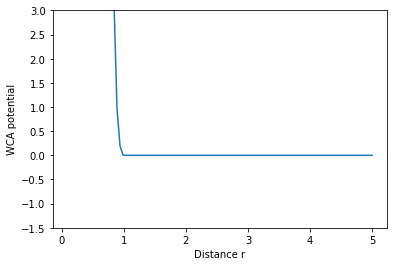

In [10]:
# Redefine potential
epsilon = 1
rm = 1.0
sigma = rm * 2**(-1/6)
cutOff = 5
potentialWCA = WCA(epsilon, sigma)

# Construct evaluate function
def WCAevaluate(r):
    p1 = np.zeros(3)
    p2 = np.array([r,0,0])
    vel = np.zeros(3)
    part1 = msmrd2.particle(1.0, p1, vel, 1)
    part2 = msmrd2.particle(1.0, p2, vel, 1)
    return potentialWCA.evaluate(part1, part2)

rarray = np.linspace(0.1,5,100)
V_WCA = [WCAevaluate(r) for r in rarray]
plt.plot(rarray, V_WCA)
plt.xlabel("Distance r")
plt.ylabel("WCA potential")
plt.ylim([-1.5,3])
plt.show()